# Lights Out

Amongst the various logic and combinatorial puzzles, the classic game of Lights Out presents a unique strategic
challenge. The goal of the puzzle is to transform a grid of lights – where each light can be toggled between on and
off – into a state where all lights are turned off. This deceptively simple problem requires careful planning and
systematic decision-making (Fleischer & Yu, 2013). Hence, we believe that artificial intelligence (AI) agents offer
a powerful tool to analyse this puzzle – to explore potential solutions and discover the optimal sequence of toggles
to solve it.

In [48]:
import numpy as np
import matplotlib.pyplot as plt

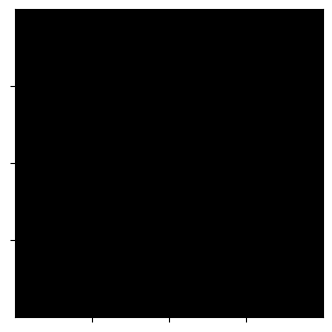

Number of Lights On: 16


In [49]:
# seed game
# np.random.seed(1234) 

class LightsOutGame:
    """ 
    Implementation of Lights Out game using a 2D array
    """

    def __init__(self, M, N):
        # game grid size
        self._M = M
        self._N = N
        # self._game_grid = np.random.choice([0, 1], size=(self._M, self._N)) # initialise game grid
        self._game_grid = np.ones(shape=(self._M, self._N))

        self._num_lights = np.count_nonzero(self._game_grid == 1)
        self._adj_dir = [[0, 0], [-1, 0], [1, 0], [0, -1], [0, 1]] # direction of tiles whether bits need to be flipped on click
        self.click_path = []
        self.key = self._gen_key()

    def click(self, x_pos, y_pos):
        if self.has_ended():
            return
        
        # keep track of what we click
        self.click_path.append((x_pos, y_pos))

        for dir in self._adj_dir:
            x = x_pos + dir[0]
            y = y_pos + dir[1]

            if x < 0 or x >= self._M or y < 0 or y >= self._N:
                continue
            
            # adjust lights on count
            if self._game_grid[x, y]:
                self._num_lights -= 1
            else:
                self._num_lights += 1

            self._game_grid[x, y] = not self._game_grid[x, y] # flip bit of clicked tile
        
        self.key = self._gen_key() # update board key

    def has_ended(self):
        return self._num_lights == 0

    def get_num_of_clicks(self):
        return len(self.click_path)
    
    def get_state_key(self):
        return self.key

    def print_game(self):
        (height, width) = self._game_grid.shape
        grid = self._game_grid * 255  # match standard pixel values (0 to 255) in grayscale

        plt.figure(figsize=(width, height))
        plt.imshow(grid, cmap='Greys', vmin=0, vmax=255)

        # Add gridlines
        plt.grid(True, which='both', color='black', linewidth=1)

        # we need to offset the grid lines to match tiles
        plt.xticks([x-0.5 for x in range(1, width)], [])
        plt.yticks([y-0.5 for y in range(1, height)], [])         
        plt.show()

        print("Number of Lights On:", self._num_lights)


    def _check_solvable_game(self):
        """ 
        ONLY VALID FOR 5x5 (i think)

        Not all Lights Out games are solvable. Hence we will need to run a test to ensure
        games generated are all solvable.
        https://puzzling.stackexchange.com/questions/123075/how-do-i-determine-whether-a-5x5-lights-out-puzzle-is-solvable-without-trying-to
        """

        count = 0 

        # row-checking
        for i in [0, 2, 4]:
            count += self._game_grid[i][0]
            count += self._game_grid[i][1]
            count += self._game_grid[i][3]
            count += self._game_grid[i][4]
        
        if count % 2 != 0:
            return False
        
        count = 0
        # col checking
        for i in [0, 2, 4]:
            count += self._game_grid[0][i]
            count += self._game_grid[1][i]
            count += self._game_grid[3][i]
            count += self._game_grid[4][i]

        if count % 2 != 0:
            return False
        
        return True


    def _gen_key(self):
        return ''.join(self._game_grid.flatten().astype(int).astype(str))


game = LightsOutGame(4, 4)
game.print_game()

# Implementation of Our Agent

The goal of Lights Out is to toggle all switches off in the minimum number of moves given the unique bit flipping pattern upon click.

In [50]:
import queue
import copy


class LightsOutSolver:

    def __init__(self):
        self.memo_table = {} # cache previously seen before moves


    def solve(self, game: LightsOutGame):
        """ 
        Solving using BFS
        """

        min_moves = float('inf')
        best_path = None
        hit = 0
        q = queue.Queue() # FIFO queue
        q.put(copy.deepcopy(game)) # put a deep copy of the game into the queue
        processed_count = 0

        while not q.empty():
            processed_count += 1
            curr_game_state: LightsOutGame = q.get()

            if processed_count % 1000 == 0:
                print("States iterated:", processed_count, len(self.memo_table))
                if best_path:
                    print("Current best path:", best_path)
                    print("Best path length:", min_moves)

            if curr_game_state.has_ended():
                if curr_game_state.get_num_of_clicks() < min_moves:
                    min_moves = curr_game_state.get_num_of_clicks()
                    best_path = curr_game_state.click_path
                break
            
            for i in range(curr_game_state._M):
                for j in range(curr_game_state._N):
                    next_game_state = copy.deepcopy(curr_game_state)
                    next_game_state.click(i, j)

                     # check if we have seen this state before
                    if next_game_state.get_state_key() in self.memo_table:
                        hit += 1 # just to track how many times we see a previous cached position
                        cached_state_path = self.memo_table[next_game_state.get_state_key()]
                        if len(cached_state_path) < len(next_game_state.click_path):
                            next_game_state.click_path = cached_state_path
                        else:
                            # optimisation step to skip loops
                            self.memo_table[next_game_state.get_state_key()] = next_game_state.click_path
                            continue
                    else: 
                        self.memo_table[next_game_state.get_state_key()] = next_game_state.click_path
                
                    q.put(next_game_state)

        print(hit, processed_count)        
        return min_moves, best_path, processed_count


solver = LightsOutSolver()
ans = solver.solve(game)

States iterated: 1000 2263
States iterated: 2000 3268
30900 2139


In [51]:
ans

(4, [(0, 1), (1, 3), (2, 0), (3, 2)], 2139)

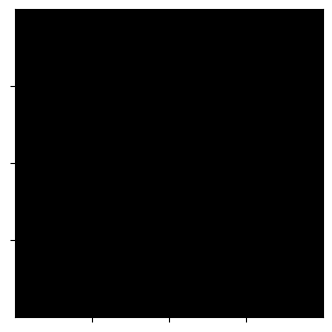

Number of Lights On: 16


In [52]:
# seed game
game = LightsOutGame(4, 4)
game.print_game()

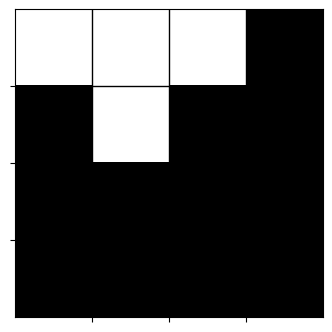

Number of Lights On: 12


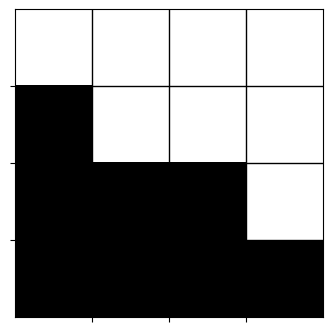

Number of Lights On: 8


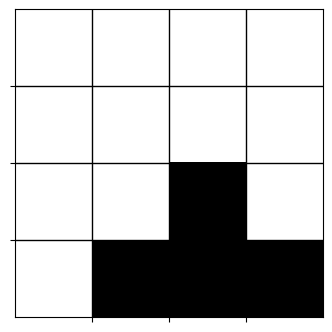

Number of Lights On: 4


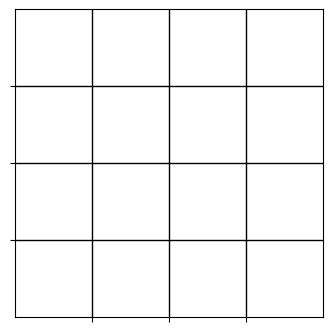

Number of Lights On: 0


In [53]:
game.click(0, 1)
game.print_game()
game.click(1, 3)
game.print_game()
game.click(2, 0)
game.print_game()
game.click(3, 2)
game.print_game()